# Tools for SUITE Risk-Limiting Election Audits

This Jupyter notebook implements some tools to conduct "hybrid" stratified risk-limiting audits as described in Risk-Limiting Audits by Stratified Union-Intersection Tests of Elections (SUITE), by Ottoboni, Stark, Lindeman, and McBurnett.

For an implementation of tools for "comparison" risk-limiting audits as described in AGI, see http://statistics.berkeley.edu/~stark/Vote/auditTools.htm. For the sister ballot polling tool, see https://www.stat.berkeley.edu/~stark/Vote/ballotPollTools.htm.

The tools on this page help perform the following steps:

* Choose a number of ballots to audit in each stratum initially, on the assumption that the contest outcome is correct.
* Select random samples of ballots in each stratum.
* Find those ballots using ballot manifests.
* Determine whether the audit can stop, given the votes on the ballots in the sample. 
* If the audit cannot stop yet, estimate how many additional ballots will need to be audited.

This notebook is already filled out with an example election. It can be run from start to finish to demonstrate how the tool works. The numbers in the example can be deleted and replaced with actual data for an audit.

## Introduction to Jupyter Notebooks

We leave [a comprehensive introduction to the Jupyter notebook](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html) to the experts, but below are a few features you should know to use this tool:

* notebooks are comprised of _cells_, blocks of code that can be run together. To the left of a code cell, you will see either [] (indicating that it has not been run yet) or [x] (where x is a number indicating that it was the xth cell to be run). You can the code in a cell by clicking into the cell, indicated by a green box around the cell, and running `Ctrl + Enter`.
* code lines that begin with `#` are comments. They're not actually run, but are there to describe what the code is doing.
* the text in a notebook is also written in a cell. Instead of a code cell, it's a Markdown cell. Clicking on a text cell will make it editable; running `Ctrl + Enter` will render it back into text.
* the order in which cells are executed matters. Code in later cells depends on earlier cells. However, it is _possible_ to run cells out of order or rerun cells that have been run earlier; this can cause problem. In general, it is __best practice__ to rerun the entire notebook after you have filled in the values you want. To do so, click on the `Kernel` menu at the top of the page and select `Restart & Run All`. This will clear the memory and rerun everything in the prescribed order.


The following cell imports all the necessary functionality from packages.

In [1]:
from __future__ import print_function

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display, HTML

from collections import OrderedDict
from itertools import product
import math
import json
import pprint

import numpy as np
from ballot_comparison import ballot_comparison_pvalue
from fishers_combination import  maximize_fisher_combined_pvalue, create_modulus
from sprt import ballot_polling_sprt

from cryptorandom.cryptorandom import SHA256
from cryptorandom.sample import random_sample

from suite_tools import write_audit_parameters, write_audit_results, \
        check_valid_audit_parameters, check_valid_vote_counts, \
        check_overvote_rates, find_winners_losers, print_reported_votes, \
        estimate_n, estimate_escalation_n, \
        parse_manifest, unique_manifest, find_ballot, \
        audit_contest, check_polling_sample_size, plot_nratio_sample_sizes
    
import warnings
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Input the global audit parameters.

For an audit, you should input the following global parameters in the cell below:

* contest-specific parameters:
    * `risk_limit`: the risk limit for the audit
    * `stratum_sizes`: total ballots in the two strata, [CVR total, no-CVR total]
    * `num_winners`: number of winners in the contest
* software parameters:
    * `seed`: the numeric seed for the pseudo-random number generator used to draw samples of ballots. Use, e.g., 20 rolls of a 10-sided die 
    * `gamma`: the gamma parameter used in the ballot-polling method from Lindeman and Stark (2012). Default value of 1.03905 is generally accepted
    * `lambda_step`: the initial step size in the grid search over the way error is allocated across the CVR and no-CVR strata in SUITE. Default 0.05 is acceptable
* initial sample size estimate parameters:
    * `o1_rate`: expected rate of 1-vote overstatements in the CVR stratum
    * `o2_rate`: expected rate of 2-vote overstatements in the CVR stratum
    * `u1_rate`: expected rate of 1-vote understatements in the CVR stratum
    * `u2_rate`: expected rate of 2-vote understatements in the CVR stratum
    * `n_ratio`: what fraction of the sample is taken from the CVR stratum. Default is to allocate sample in proportion to ballots cast in each stratum.
    


In [2]:
# contest-specific parameters
risk_limit = 0.05    # risk limit
stratum_sizes = [100000, 5000]  # total ballots in the two strata, CVR, no-CVR
num_winners = 2      # maximum number of winners, per social choice function

In [3]:
# software parameters
seed = 12345678901234567890  # use, e.g., 20 rolls of a 10-sided die
gamma=1.03905         # gamma from Lindeman and Stark (2012)
lambda_step = 0.05    # stepsize for the discrete bounds on Fisher's combining function

In [4]:
# initial sample size parameters
o1_rate = 0.002       # expect 2 1-vote overstatements per 1000 ballots in the CVR stratum
o2_rate = 0           # expect 0 2-vote overstatements
u1_rate = 0           # expect 0 1-vote understatements
u2_rate = 0           # expect 0 2-vote understatements
n_ratio = stratum_sizes[0]/np.sum(stratum_sizes) 
                     # allocate sample in proportion to ballots cast in each stratum

In [5]:
check_valid_audit_parameters(risk_limit, lambda_step, o1_rate, o2_rate, \
                                 u1_rate, u2_rate, stratum_sizes, n_ratio, num_winners)

In [6]:
write_audit_parameters("audit_parameters.json",\
                       risk_limit, stratum_sizes, num_winners, seed, gamma, \
                       lambda_step, o1_rate, o2_rate, \
                       u1_rate, u2_rate, n_ratio)

# Enter the reported votes

Candidates are stored in a data structure called a dictionary. Enter the candidate name and the votes in each stratum, [votes in CVR stratum, votes in no-CVR stratum], in the cell below. The following cell will calculate the vote totals, margins, winners, and losers.

In [7]:
# input number of winners
# input names as well as reported votes in each stratum

# candidates are a dict with name, [votes in CVR stratum, votes in no-CVR stratum]
candidates = { "candidate 3": [30000, 500],
               "candidate 2": [50000, 1000],
               "candidate 1": [10000, 500],
               "candidate 4": [500, 10]}

# Run validity check on the input vote totals
check_valid_vote_counts(candidates, num_winners, stratum_sizes)

In [8]:
# compute reported winners, losers, and pairwise margins. Nothing should be printed.
(candidates, margins, winners, losers) = find_winners_losers(candidates, num_winners)
  
# Check that overstatement rates are compatible with the reported results
check_overvote_rates(margins=margins, total_votes=sum(stratum_sizes), 
                     o1_rate=o1_rate, o2_rate=o2_rate)

In [9]:
# print reported winners, losers, and pairwise margins
print_reported_votes(candidates, winners, losers, margins, stratum_sizes,\
                     print_alphabetical=False)


Total reported votes:
			CVR	no-CVR	total	% of all votes	% of valid votes
	 candidate 2 : 50000 	 1000 	 51000 	 48.57% 	 55.13%
	 candidate 3 : 30000 	 500 	 30500 	 29.05% 	 32.97%
	 candidate 1 : 10000 	 500 	 10500 	 10.00% 	 11.35%
	 candidate 4 : 500 	 10 	 510 	 0.49% 	 0.55%

	 valid votes:	 90500 	 2010 	 92510 	 88.10%

	 non-votes:	 9500 	 2990 	 12490 	 11.90%

Reported winners:
	 candidate 2
	 candidate 3

Reported losers:
	 candidate 1
	 candidate 4


Reported margins:
	 candidate 2 beat candidate 4 by 50,490 votes
	 candidate 2 beat candidate 1 by 40,500 votes
	 candidate 3 beat candidate 4 by 29,990 votes
	 candidate 3 beat candidate 1 by 20,000 votes

Smallest reported margin: 20,000 
Corresponding reported diluted margin: 19.05%


# Initial sample size estimates.

The initial sample size tool helps you anticipate the number of randomly selected ballots that might need to be inspected to attain a given limit on the risk, under the assumption that the reported percentages for each candidate are correct. 

It is completely legitimate to sample one at a time and rerun the SUITE calculations, but this form can help auditors anticipate how many ballots the audit is likely to require and to retrieve ballots more efficiently.

This code will estimate the sample size needed to attain the desired risk limit in an audit of the contest between each pair of winning and losing candidates. The overall sample size will be allocated to the CVR stratum in `n_ratio` proportion and to the no-CVR stratum in `1-n_ratio` proportion. The sample size estimates for each pair will be printed below. The expected sample size needed for the audit is the _maximum_ of the sample sizes for each winner, loser pair: the sample must be large enough to confirm the closest margin.

Taking a larger initial sample can avoid needing to expand the sample later, depending on the rate of ballots for each candidate in the sample. Avoiding "escalation" can make the audit less complicated.


In [10]:
# Calculate expected sample size across (winner, loser) pairs

sample_sizes = {}

for k in product(winners, losers):
    sample_sizes[k] = estimate_n(N_w1 = candidates[k[0]][0],\
                                 N_w2 = candidates[k[0]][1],\
                                 N_l1 = candidates[k[1]][0],\
                                 N_l2 = candidates[k[1]][1],\
                                 N1 = stratum_sizes[0],\
                                 N2 = stratum_sizes[1],\
                                 o1_rate = o1_rate,\
                                 o2_rate = o2_rate,\
                                 u1_rate = u1_rate,\
                                 u2_rate = u2_rate,\
                                 n_ratio = n_ratio,\
                                 risk_limit = risk_limit,\
                                 gamma = gamma,\
                                 stepsize = lambda_step,\
                                 min_n = 5,\
                                 risk_limit_tol = 0.8)

In [11]:
sample_size = np.amax([v[0]+v[1] for v in sample_sizes.values()])

print("estimated sample sizes for each contest:\n")
pprint.pprint(sample_sizes)
print('\n\nexpected minimum sample size needed to confirm all pairs:', sample_size)

estimated sample sizes for each contest:

{('candidate 2', 'candidate 1'): (30, 1),
 ('candidate 2', 'candidate 4'): (23, 1),
 ('candidate 3', 'candidate 1'): (67, 3),
 ('candidate 3', 'candidate 4'): (45, 2)}


expected minimum sample size needed to confirm all pairs: 70


In [12]:
check_polling_sample_size(candidates, winners, losers, stratum_sizes, risk_limit)



expected minimum sample size that would be needed using ballot polling ONLY, for all ballots: 69


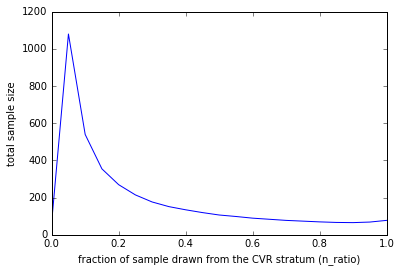

In [40]:
# Run this cell to plot the total size as a function of n_ratio

plot_nratio_sample_sizes(candidates, winners, losers, stratum_sizes, n_ratio_step=0.05,\
                         o1_rate=o1_rate)

# Random sampling

The next tool helps generate pseudo-random samples of ballots in each stratum. Further below, there is a form to help find the individual, randomly selected ballots among the batches in which ballots are stored.

The first cell below initializes the SHA-256 cryptographically secure pseudo-random number generator. Details on why you might want to use this pseudo-random number generator instead of the Python default can be found in [Stark and Ottoboni (2018)](https://arxiv.org/abs/1810.10985). 

Input your desired sample sizes in the second cell below. Input the number of ballots you want in the sample. The default values that are pre-filled are taken from the initial sample size estimates above. 

The third cell should not be modified. It draws the samples from each stratum, using sampling _with_ replacement for the CVR stratum and sampling _without_ replacement for the no-CVR stratum. This means that some ballots in the CVR stratum could be sampled more than once.


**NOTE:**
If this section is giving errors, you probably need to update your version of `cryptorandom`.

```
pip install [--update] cryptorandom
```

In [14]:
# initialize the PRNG
prng = SHA256(seed)   

In [15]:
# Input the sample sizes for each stratum. 
# Defaults to those found using the initial sample size tool above.
n1 = math.ceil(sample_size*n_ratio)    
n2 = sample_size-n1

In [16]:
# CVR stratum initial sample size, sampled with replacement
sample1 = prng.randint(1, stratum_sizes[0]+1, size=n1)

# No-CVR ballots are sampled without replacement
sample2 = random_sample(stratum_sizes[1], size=n2, replace=False, prng=prng)

### CVR stratum sample

In [17]:
print("CVR stratum sample:\n", sample1)

CVR stratum sample:
 [76116 45424 33501 45326  2081 56264 25122 16602 79743 61814 57922 41676
 95332 38891 17757 64352 84257 47365 10908 97791 77941 73573 51855 88527
 35549 20934 61419 70683 70220 45067 67903 94304 20823 50570 88735  9973
 44578 34320  8262 32532 85102 87511 63375 96612 52917 91127 84152 74227
 76674 76640 62444 83868  3974 81503 82205 41161 28136 12244 97608  9057
 43082  6522 39347 45600 57836 10233 75516]


In [18]:
print("CVR stratum sample, sorted:\n", np.sort(sample1))

CVR stratum sample, sorted:
 [ 2081  3974  6522  8262  9057  9973 10233 10908 12244 16602 17757 20823
 20934 25122 28136 32532 33501 34320 35549 38891 39347 41161 41676 43082
 44578 45067 45326 45424 45600 47365 50570 51855 52917 56264 57836 57922
 61419 61814 62444 63375 64352 67903 70220 70683 73573 74227 75516 76116
 76640 76674 77941 79743 81503 82205 83868 84152 84257 85102 87511 88527
 88735 91127 94304 95332 96612 97608 97791]


In [19]:
print("CVR stratum sample, sorted, duplicates removed:\n", np.unique(np.sort(sample1)))

CVR stratum sample, sorted, duplicates removed:
 [ 2081  3974  6522  8262  9057  9973 10233 10908 12244 16602 17757 20823
 20934 25122 28136 32532 33501 34320 35549 38891 39347 41161 41676 43082
 44578 45067 45326 45424 45600 47365 50570 51855 52917 56264 57836 57922
 61419 61814 62444 63375 64352 67903 70220 70683 73573 74227 75516 76116
 76640 76674 77941 79743 81503 82205 83868 84152 84257 85102 87511 88527
 88735 91127 94304 95332 96612 97608 97791]


In [20]:
m = np.zeros_like(sample1, dtype=bool)
m[np.unique(sample1, return_index=True)[1]] = True
print("CVR stratum repeated ballots:\n", sample1[~m])

CVR stratum repeated ballots:
 []


### No-CVR sample

In [21]:
print("No-CVR stratum sample:\n", sample2)

No-CVR stratum sample:
 [1782 4274 4914]


In [22]:
print("No-CVR stratum sample, sorted:\n", np.sort(sample2))

No-CVR stratum sample, sorted:
 [1782 4274 4914]


# Find ballots using ballot manifest

Generally, ballots will be stored in batches, for instance, separated by precinct and mode of voting. To make it easier to find individual ballots, it helps to have a ballot manifest that describes how the ballots are stored. 


Batch label	| ballots
--- |  ---
Polling place precinct 1  |	130
Vote by mail precinct 1	  | 172
Polling place precinct 2  | 112
Vote by mail precinct 2	  | 201
Polling place precinct 3  | 197
Vote by mail precinct 3   | 188


If ballot 500 is selected for audit, which ballot is that? If we take the listing of batches in the order given by the manifest, and we require that within each batch, the ballots are in an order that does not change during the audit, then the 500th ballot is the 86th ballot among the vote by mail ballots for precinct 2: The first three batches have a total of 130+172+112 = 414 ballots. The first ballot in the fourth batch is ballot 415. Ballot 500 is the 86th ballot in the fourth batch. The ballot look-up tool transforms a list of ballot numbers and a ballot manifest into a list of ballots in each batch.

There must be separate ballot manifests for ballots in the CVR stratum and for ballots in the no-CVR stratum. The manifests should be input as a Python structure called a _list_. Lists are stored in square brackets, `[` `]`, and items in the list are separated by commas.

Each ballot manifest entry must have a batch label, a comma, and one of the following:
  1. the number of ballots in the batch 
  1. a range specified with a colon (e.g., 131:302), or 
  1. a list of ballot identifiers within parentheses, separated by spaces (e.g., (996 998 1000)).

Each line should have exactly one comma; do **not** include commas in the batch label.

The total number of ballots in the manifest must equal the number cast in the contest that is to be audited using the sample.

In [23]:
# Suppose the ballot manifests are manually entered for now.

ballot_manifest_cvr = ['1, 10000', 
                       '2, 10001:99998', 
                       '3, (205 210)'
                      ]
ballot_manifest_poll = ['1, 1000', 
                        '2, 1001:4998', 
                        '3, (205 210)'
                       ]

In [24]:
# step 1: expand the ballot manifest into a dict. keys are batches, values are ballot numbers.
cvr_manifest_parsed = parse_manifest(ballot_manifest_cvr)
poll_manifest_parsed = parse_manifest(ballot_manifest_poll)

In [25]:
# count ballots listed in the manifests
listed_cvr = np.sum([len(v) for v in cvr_manifest_parsed.values()])
listed_poll = np.sum([len(v) for v in poll_manifest_parsed.values()])

# test that manifest matches reported ballot totals

assert listed_cvr == stratum_sizes[0]
assert listed_poll == stratum_sizes[1]

In [26]:
# step 2: give ballots unique IDs

unique_cvr_manifest = unique_manifest(cvr_manifest_parsed)
unique_poll_manifest = unique_manifest(poll_manifest_parsed)

In [27]:
# step 3: look up sample values

print("CVR Stratum")

cvr_sample = []
for s in sample1[m]:
    original_ballot_label, batch_label, which_ballot = find_ballot(s, \
                                                                   unique_cvr_manifest, \
                                                                   cvr_manifest_parsed)
    if s in sample1[~m]:
        cvr_sample.append([s, batch_label, which_ballot, np.sum(np.array(sample1) == s)])
    else:
        cvr_sample.append([s, batch_label, which_ballot, 1])
        
cvr_sample.sort(key=lambda x: x[2]) # Sort second on order within batches
cvr_sample.sort(key=lambda x: x[1]) # Sort first based on batch label
cvr_sample.insert(0,["sampled ballot", "batch label", "which ballot in batch", "# times sampled"])

display(HTML(
    '<table><tr>{}</tr></table>'.format(
        '</tr><tr>'.join(
            '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in cvr_sample)
        )
 ))

CVR Stratum


sampled ballot,batch label,which ballot in batch,# times sampled
2081,1,2081,1
3974,1,3974,1
6522,1,6522,1
8262,1,8262,1
9057,1,9057,1
9973,1,9973,1
10233,2,233,1
10908,2,908,1
12244,2,2244,1
16602,2,6602,1


In [28]:
print("Polling Stratum")

nocvr_sample = []
for s in sample2:
    original_ballot_label, batch_label, which_ballot = find_ballot(s, \
                                                                   unique_poll_manifest, \
                                                                   poll_manifest_parsed)
    nocvr_sample.append([s, batch_label, which_ballot])

nocvr_sample.sort(key=lambda x: x[2]) # Sort second on order within batches
nocvr_sample.sort(key=lambda x: x[1]) # Sort first based on batch label
nocvr_sample.insert(0,["sampled ballot", "batch label", "which ballot in batch"])

display(HTML(
    '<table><tr>{}</tr></table>'.format(
        '</tr><tr>'.join(
            '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in nocvr_sample)
        )
 ))

Polling Stratum


sampled ballot,batch label,which ballot in batch
1782,2,782
4274,2,3274
4914,2,3914


# Enter the sample data

## Sample statistics for the CVR stratum (stratum 1)

In [29]:
print("The sample size in the CVR stratum was", n1)

The sample size in the CVR stratum was 67


In [30]:
# Number of observed...

def cvr_audit_inputs(o1, o2, u1, u2):
    return (o1, o2, u1, u2)

cvr_stats = interactive(cvr_audit_inputs,
                             o1 = widgets.IntSlider(min=0,max=n1,value=0),
                             u1 = widgets.IntSlider(min=0,max=n1,value=0),
                             o2 = widgets.IntSlider(min=0,max=n1,value=0),
                             u2 = widgets.IntSlider(min=0,max=n1,value=0))
display(cvr_stats)

(0, 0, 0, 0)

In [31]:
(o1, o2, u1, u2) = [cvr_stats.children[i].value for i in range(4)]

## Sample statistics for the no-CVR stratum (stratum 2)

In [32]:
print("The sample size in the no-CVR stratum was", n2)

The sample size in the no-CVR stratum was 3


In [33]:
nocvr_widgets=[]

# create the widgets
for name in candidates.keys():
    nocvr_widgets.append(widgets.IntSlider(value=0,min=0,max=n2,description=name))

# It'd be great to constrain their sum to be <= n2

#for widget in nocvr_widgets:
#    widget.observe(lambda change:myfct(change,nocvr_widgets),names='value',type='change')

# group the widgets into a FlexBox
nocvr_audit_inputs = widgets.VBox(children=nocvr_widgets)

# display the widgets
display(nocvr_audit_inputs)

In [34]:
# no-CVR sample is stored in a dict with name, votes in the sample

observed_poll = {}
for widget in nocvr_widgets:
    observed_poll[widget.description] = widget.value

assert np.sum(list(observed_poll.values())) <= n2, "Too many ballots input"
pprint.pprint(observed_poll)


{'candidate 1': 0, 'candidate 2': 0, 'candidate 3': 0, 'candidate 4': 0}


# What's the risk for this sample?

The audit looks at every (winner, loser) pair in each contest. Auditing continues until there is strong evidence that every winner in a contest got more votes than every loser in the contest. It does this by considering (winner, loser) pairs. The SUITE risk for every pair will appear beneath the cell below after it is run. The audit continues until all the numbers are not larger than the risk limit. E.g., if the risk limit is 10%, the audit stops when the numbers in the table are all less than 0.1.

In [35]:
# Find audit p-values across (winner, loser) pairs

audit_pvalues = audit_contest(candidates, winners, losers, stratum_sizes, \
                  n1, n2, o1, o2, u1, u2, observed_poll, \
                  risk_limit=risk_limit, gamma=gamma, stepsize=lambda_step)
pprint.pprint(audit_pvalues)

{('candidate 2', 'candidate 1'): 1.60720828293881e-05,
 ('candidate 2', 'candidate 4'): 3.4873757048803355e-07,
 ('candidate 3', 'candidate 1'): 0.01204121065144581,
 ('candidate 3', 'candidate 4'): 0.0004700828165858928}


In [36]:
# Track contests not yet confirmed

contests_not_yet_confirmed = [i[0] for i in audit_pvalues.items() \
                              if i[1]>risk_limit]
print("Pairs not yet confirmed:\n", contests_not_yet_confirmed)

winners_not_yet_confirmed = list(set(list(map(lambda x: x[0], contests_not_yet_confirmed))))
losers_not_yet_confirmed = list(set(list(map(lambda x: x[1], contests_not_yet_confirmed))))

Pairs not yet confirmed:
 []


In [37]:
# Save everything to file


write_audit_results("audit_results.json", \
                        n1, n2, sample1, sample2, \
                        o1, o2, u1, u2, observed_poll, \
                        audit_pvalues, prng.getstate())

# Escalation guidance: how many more ballots should be drawn?

This tool estimates how many more ballots should be examined to confirm any remaining contests. The enlarged sample size is based on the following:
* ballots that have already been sampled
* assumption that we will continue to see overstatements and understatements at the same rate that they've been observed in the sample so far
* assumption that vote proportions in the ballot-polling stratum will reflect the reported proportions

Given these additional numbers, return to the sampling tool and draw additional ballots, find them with the ballot manifest tool, update the observed sample values, and rerun the SUITE risk calculations.

In [38]:
sample_sizes_new = {}

# Add a reminder note about the candidate dict structure.

for k in contests_not_yet_confirmed:
    sample_sizes_new[k] = estimate_escalation_n(\
                                 N_w1 = candidates[k[0]][0],\
                                 N_w2 = candidates[k[0]][1],\
                                 N_l1 = candidates[k[1]][0],\
                                 N_l2 = candidates[k[1]][1],\
                                 N1 = stratum_sizes[0],\
                                 N2 = stratum_sizes[1],\
                                 n1 = n1,\
                                 n2 = n2,\
                                 o1_obs = o1,\
                                 o2_obs = o2,\
                                 u1_obs = u1,\
                                 u2_obs = u2,\
                                 n2l_obs = observed_poll[k[1]],\
                                 n2w_obs = observed_poll[k[0]],\
                                 n_ratio = n_ratio,\
                                 risk_limit = risk_limit,\
                                 gamma = gamma,\
                                 stepsize = lambda_step,
                                 risk_limit_tol = 0.8)

In [39]:
sample_size_new = np.amax([v[0]+v[1] for v in sample_sizes_new.values()])
n1_new = np.amax([v[0] for v in sample_sizes_new.values()])
n2_new = np.amax([v[1] for v in sample_sizes_new.values()])


print("estimated sample sizes for each contest:\n")
pprint.pprint(sample_sizes_new)
print('\n\nexpected minimum sample size needed to confirm remaining pairs:', sample_size_new)
print("\nBallots to draw in the CVR stratum:", n1_new - n1)
print("Ballots to draw in the no-CVR stratum:", n2_new - n2)

ValueError: zero-size array to reduction operation maximum which has no identity

# Draw additional ballots

In [ ]:
# print the current state of the PRNG after drawing the initial samples
print(prng) 

In [ ]:
# CVR stratum sample size, sampled with replacement
sample1 = prng.randint(1, stratum_sizes[0]+1, size=n1_new - n1)

# No-CVR ballots are sampled without replacement
remaining_ballots = [i for i in range(stratum_sizes[1]) if i not in sample2]
sample2 = random_sample(remaining_ballots, size=n2_new - n2, replace=False, prng=prng)

### CVR stratum sample

In [ ]:
print("CVR stratum sample:\n", sample1)

In [ ]:
print("CVR stratum sample, sorted:\n", np.sort(sample1))

In [ ]:
print("CVR stratum sample, sorted, duplicates removed:\n", np.unique(np.sort(sample1)))

In [ ]:
m = np.zeros_like(sample1, dtype=bool)
m[np.unique(sample1, return_index=True)[1]] = True
print("CVR stratum repeated ballots:\n", sample1[~m])

### No-CVR sample

In [ ]:
print("No-CVR stratum sample:\n", sample2)

In [ ]:
print("No-CVR stratum sample, sorted:\n", np.sort(sample2))

# Find ballots using ballot manifest

In [ ]:
# look up sample values

print("CVR Stratum")

cvr_sample = []
for s in sample1[m]:
    original_ballot_label, batch_label, which_ballot = find_ballot(s, \
                                                                   unique_cvr_manifest, \
                                                                   cvr_manifest_parsed)
    if s in sample1[~m]:
        cvr_sample.append([s, batch_label, which_ballot, np.sum(np.array(sample1) == s)])
    else:
        cvr_sample.append([s, batch_label, which_ballot, 1])



cvr_sample.sort(key=lambda x: x[2]) # Sort second on order within batches
cvr_sample.sort(key=lambda x: x[1]) # Sort first based on batch label
cvr_sample.insert(0,["sampled ballot", "batch label", "which ballot in batch", "# times sampled"])

display(HTML(
    '<table><tr>{}</tr></table>'.format(
        '</tr><tr>'.join(
            '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in cvr_sample)
        )
 ))

In [ ]:
print("Polling Stratum")

nocvr_sample = []
for s in sample2:
    original_ballot_label, batch_label, which_ballot = find_ballot(s, \
                                                                   unique_poll_manifest, \
                                                                   poll_manifest_parsed)
    nocvr_sample.append([s, batch_label, which_ballot])

nocvr_sample.sort(key=lambda x: x[2]) # Sort second on order within batches
nocvr_sample.sort(key=lambda x: x[1]) # Sort first based on batch label
nocvr_sample.insert(0,["sampled ballot", "batch label", "which ballot in batch"])

display(HTML(
    '<table><tr>{}</tr></table>'.format(
        '</tr><tr>'.join(
            '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in nocvr_sample)
        )
 ))

# Enter the data from the *combined* sample

## Sample statistics for the CVR stratum (stratum 1).
Update the numbers below to include what was seen in the initial sample PLUS what was seen in the new sample.

In [ ]:
print("The initial sample size in the CVR stratum was", n1, \
      "and the new sample size was", n1_new)
print("The observed overstatements and understatements from the original sample were")
pprint.pprint({"o1" : o1, "o2" : o2, "u1" : u1, "u2" : u2})

In [ ]:
# Number of observed...

def cvr_audit_inputs(o1, o2, u1, u2):
    return (o1, o2, u1, u2)

cvr_stats = interactive(cvr_audit_inputs,
                             o1 = widgets.IntSlider(min=0,max=n1_new,value=0),
                             u1 = widgets.IntSlider(min=0,max=n1_new,value=0),
                             o2 = widgets.IntSlider(min=0,max=n1_new,value=0),
                             u2 = widgets.IntSlider(min=0,max=n1_new,value=0))
display(cvr_stats)

In [ ]:
(o1, o2, u1, u2) = [cvr_stats.children[i].value for i in range(4)]

## Sample statistics for the no-CVR stratum (stratum 2)
Update the numbers below to include what was seen in the initial sample PLUS what was seen in the new sample.

In [ ]:
print("The initial sample size in the no-CVR stratum was", n2, \
      "and the new sample size was", n2_new)
print("The observed tallies from the original sample were")
pprint.pprint(observed_poll)

In [ ]:
nocvr_widgets=[]

# create the widgets
for name in candidates.keys():
    nocvr_widgets.append(widgets.IntSlider(value=0,min=0,max=n2_new,description=name))

# It'd be great to constrain their sum to be <= n2_new

#for widget in nocvr_widgets:
#    widget.observe(lambda change:myfct(change,nocvr_widgets),names='value',type='change')

# group the widgets into a FlexBox
nocvr_audit_inputs = widgets.VBox(children=nocvr_widgets)

# display the widgets
display(nocvr_audit_inputs)

In [ ]:
# no-CVR sample is stored in a dict with name, votes in the sample

observed_poll = {}
for widget in nocvr_widgets:
    observed_poll[widget.description] = widget.value

assert np.sum(list(observed_poll.values())) <= n2_new, "Too many ballots input"
pprint.pprint(observed_poll)


# What's the risk for this sample?

The audit looks at every (winner, loser) pair in each contest. Auditing continues until there is strong evidence that every winner in a contest got more votes than every loser in the contest. It does this by considering (winner, loser) pairs. The SUITE risk for every pair will appear beneath the cell below after it is run. The audit continues until all the numbers are not larger than the risk limit. E.g., if the risk limit is 10%, the audit stops when the numbers in the table are all less than 0.1.

In [ ]:
# Find audit p-values across (winner, loser) pairs

audit_pvalues = audit_contest(candidates, winners_not_yet_confirmed, \
                              losers_not_yet_confirmed, stratum_sizes, \
                              n1_new, n2_new, o1, o2, u1, u2, observed_poll, \
                              risk_limit=risk_limit, gamma=gamma, stepsize=lambda_step)
pprint.pprint(audit_pvalues)

In [ ]:
# Track contests not yet confirmed

contests_not_yet_confirmed = [i[0] for i in audit_pvalues.items() \
                              if i[1]>risk_limit]
print("Pairs not yet confirmed:\n", contests_not_yet_confirmed)

In [ ]:
# Save everything to file


write_audit_results("audit_results2.json", \
                        n1_new, n2_new, sample1, sample2, \
                        o1, o2, u1, u2, observed_poll, \
                        audit_pvalues, prng.getstate())